### Soccermatics
#### Assignment 1
##### Instructions
1. Think of a player who you enjoyed watching at the recent Men's Euros 2020 or Women's Euros 2022.
2. What actions did they perform that were important and why?
3. Plot the actions and describe how the data supports or contradicts your own analysis.
4. Collect some statistics on that player for the tournament and put them in context.
5. Write a short text using at most two figures that illustrate your point.

I have chosen the Women's World Cup 2019 as Australia featured in this tournament.

I analyse Ellie Carpenter's carries of the ball, with particular focus on carries that progress the ball more than five metres forward and where these carries started from.

In [1]:
import pandas as pd
import numpy as np

import inflect

import matplotlib as mpl
import matplotlib.pyplot as plt
from mplsoccer import Sbopen, Pitch

In [2]:
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
COLOUR_BACKGROUND = '#f7f3ed'
COLOUR_ALMOST_BLACK = '#323232'
COLOUR_BLUE = '#1c7ed6'
COLOUR_PINK = '#d6336c'

In [4]:
STATSBOMB_HALFWAY = 60

In [5]:
wwc_competition_id = 72
wwc_season_id = 30

In [6]:
parser = Sbopen()

In [7]:
df_matches = parser.match(competition_id=wwc_competition_id, season_id=wwc_season_id)

In [8]:
df_matches_australia = df_matches[(df_matches['home_team_country_name']=='Australia') | (df_matches['away_team_country_name']=='Australia')].sort_values('kick_off')

In [9]:
events = {}
related_events = {}
freezes = {}
tactics = {}

for match_id in df_matches_australia['match_id']:
    events[match_id], related_events[match_id], freezes[match_id], tactics[match_id] = parser.event(match_id)


In [10]:
def filter_for_player_and_event(df, player_name, event_type_name):
    df_filtered = df[(df['player_name']==player_name) & (df['type_name']==event_type_name)]
    return df_filtered

In [11]:
def plot_lines(df, colour_attacking_half, colour_defensive_half, min_dx=0):
    long_carries_from_attacking_half = 0
    long_carries_from_defensive_half = 0

    circles = []
    arrows  = []

    for i, event in df.iterrows():

        dx = event['end_x']-event['x']
        dy = event['end_y']-event['y']
        
        if dx >= min_dx:
            if event['x'] > STATSBOMB_HALFWAY:
                colour = colour_attacking_half
                long_carries_from_attacking_half += 1
            else:
                colour = colour_defensive_half
                long_carries_from_defensive_half += 1
                
            circle = plt.Circle((event['x'], event['y']), 1.5, color=colour)
            circle.set_alpha(.2)
            circles.append(circle)

            arrow = mpl.patches.FancyArrowPatch((event['x'], event['y']),
                                (event['end_x'], event['end_y']), arrowstyle='-|>', shrinkA=0, shrinkB=0, color=colour, alpha=0.7, mutation_scale=15)
            arrows.append(arrow)

    return circles, arrows, long_carries_from_attacking_half, long_carries_from_defensive_half


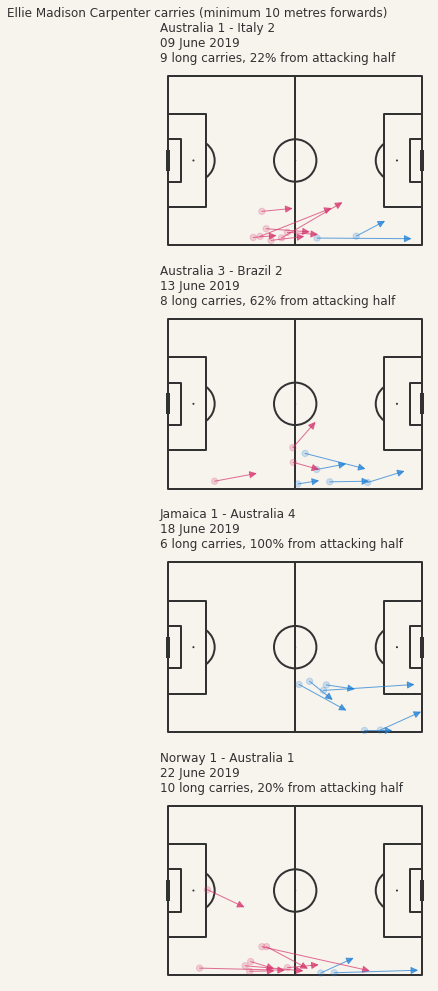

In [12]:
player_name = 'Ellie Madison Carpenter'
event_type_name = 'Carry'
min_dx = 10

pitch = Pitch(pitch_color=COLOUR_BACKGROUND, line_color=COLOUR_ALMOST_BLACK,
              line_zorder=1)

fig, ax = pitch.draw(nrows=4, ncols=1, figsize=(10,14))

fig.patch.set_facecolor(COLOUR_BACKGROUND)

for i, match_id in enumerate(events.keys()):
    df_temp = events[match_id]
    home_team_country = df_matches[df_matches['match_id']==match_id]['home_team_country_name'].iloc[0]
    home_team_score   = df_matches[df_matches['match_id']==match_id]['home_score'].iloc[0]
    away_team_country = df_matches[df_matches['match_id']==match_id]['away_team_country_name'].iloc[0]
    away_team_score   = df_matches[df_matches['match_id']==match_id]['away_score'].iloc[0]
    match_date        = df_matches[df_matches['match_id']==match_id]['match_date'].iloc[0]
    match_name = home_team_country + ' ' + str(home_team_score) + ' - ' + away_team_country + ' ' + str(away_team_score) + '\n' + match_date.strftime('%d %B %Y')

    df_player_events = filter_for_player_and_event(df_temp, player_name, event_type_name)

    circles, arrows, long_carries_from_attacking_half, long_carries_from_defensive_half = plot_lines(df_player_events, colour_attacking_half=COLOUR_BLUE, colour_defensive_half=COLOUR_PINK, min_dx=min_dx)
    for circle in circles:
        ax.flatten()[i].add_patch(circle)
    for arrow in arrows:
        ax.flatten()[i].add_patch(arrow)

    total_long_carries = long_carries_from_attacking_half + long_carries_from_defensive_half
    percent_from_attacking_half = long_carries_from_attacking_half / total_long_carries

    subplot_title = match_name + '\n' + str(total_long_carries) + ' long carries, ' + f'{percent_from_attacking_half:.0%}' + ' from attacking half'

    ax.flatten()[i].set_title(subplot_title, color=COLOUR_ALMOST_BLACK, ha='left', loc='left')



if min_dx:
    title_additional = ' (minimum ' + str(min_dx) + ' metres forwards)'

p = inflect.engine()

fig.suptitle(player_name + ' ' + p.plural(event_type_name.lower()) + title_additional, color=COLOUR_ALMOST_BLACK, ha='left', x=0.1);

fig.savefig('temp.pdf', bbox_inches='tight')
